images/bees.jpg


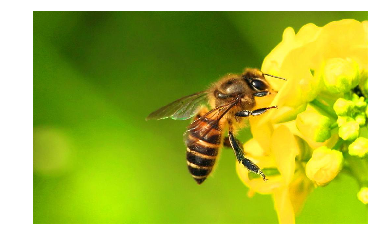

bee （score = 0.89668)
fly （score = 0.02486)
rapeseed （score = 0.02119)
apiary, bee house （score = 0.00181)
honeycomb （score = 0.00099)

images/cat.jpg


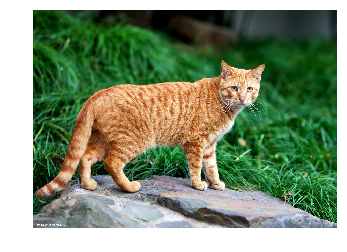

tiger cat （score = 0.89037)
tabby, tabby cat （score = 0.06482)
Egyptian cat （score = 0.00931)
lynx, catamount （score = 0.00169)
tiger, Panthera tigris （score = 0.00133)

images/dog.jpg


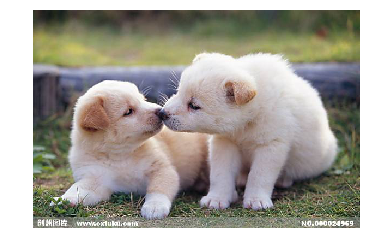

kuvasz （score = 0.17631)
chow, chow chow （score = 0.06966)
golden retriever （score = 0.05530)
Great Pyrenees （score = 0.05160)
Labrador retriever （score = 0.03835)

images/mouse.jpg


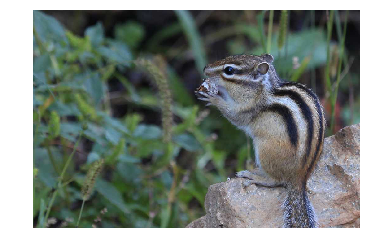

badger （score = 0.01687)
quail （score = 0.01356)
wood rabbit, cottontail, cottontail rabbit （score = 0.01109)
zebra （score = 0.01046)
whiptail, whiptail lizard （score = 0.00978)

images/pig.jpg


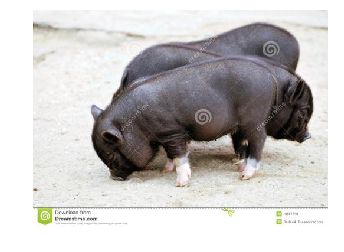

hog, pig, grunter, squealer, Sus scrofa （score = 0.39393)
hippopotamus, hippo, river horse, Hippopotamus amphibius （score = 0.11767)
wild boar, boar, Sus scrofa （score = 0.02515)
warthog （score = 0.01449)
Mexican hairless （score = 0.00924)

images/rouse.jpg


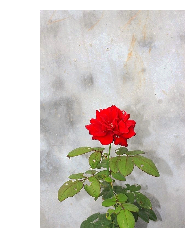

vase （score = 0.10596)
pot, flowerpot （score = 0.10101)
daisy （score = 0.04627)
bonnet, poke bonnet （score = 0.03278)
hummingbird （score = 0.02224)

images/yangyang.jpg


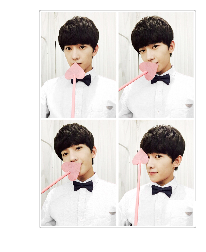

bow tie, bow-tie, bowtie （score = 0.99956)
hair slide （score = 0.00003)
bonnet, poke bonnet （score = 0.00001)
bassoon （score = 0.00001)
long-horned beetle, longicorn, longicorn beetle （score = 0.00001)



In [3]:
#导入tensorflow包
import tensorflow as tf
#OS模块简单的来说它是一个Python的系统编程的操作模块，可以处理文件和目录这些我们日常手动需要做的操作。
import os

#导入numpy
import numpy as np

#Python 的 re 模块（Regular Expression 正则表达式）提供各种正则表达式的匹配操作
import re
#python的图像库PIL
from PIL import Image
#导入画图
import matplotlib.pyplot as plt


class NodeLookup(object):#定义类
    def __init__(self):
        #初始化两条路径
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符串n*********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()#读入文件
        uid_to_human = {}#存入数据
        # 一行一行读取数据
        for line in proto_as_ascii_lines:
            # 去掉换行符
            line = line.strip('\n')
            # 按照'\t'分割
            parsed_items = line.split('\t')
            # 获取分类的编号
            uid = parsed_items[0]
            # 获取分类的名称
            human_string = parsed_items[1]
            # 保存编号字符串n********与分类名称映射关系
            uid_to_human[uid] = human_string

        # 加载分类字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}#存放在这里
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                # 获取分类编号1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):#按照冒号分割
                # 获取编号字符串n*******
                target_class_string = line.split(': ')[1]#按照冒号分割
                # 保存分类编号1-1000与编号字符串n*********映射关系
                # 有换行符\n
                node_id_to_uid[target_class] = target_class_string[1: -2]#取引号内内容

        # 建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            # 获取分类名称
            name = uid_to_human[val]
            # 建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
        return node_id_to_name

        # 传入分类编号1-1000返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]


# 创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    # 遍历目录
    for root, dirs, files in os.walk('images/'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root, file), 'rb').read()
            predictions = sess.run(softmax_tensor, {'DecodeJpeg/contents:0': image_data})  # 图片格式是jpeg格式
            predictions = np.squeeze(predictions)  # 把结果转换为1维数据

            # 打印图片路径及名称
            image_path = os.path.join(root, file)
            print(image_path)
            # 显示图片
            img = Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # 排序
            top_k = predictions.argsort()[-5:][::-1]#从小到大排序，取倒数5个，再倒序，即概率从大到小五个
            # print(top_k)
            node_lookup = NodeLookup()
            for node_id in top_k:
                # 获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                # 获取该分类的置信度
                score = predictions[node_id]
                print('%s （score = %.5f)' % (human_string, score))
            print()

